In [4]:
import numpy as np, itertools
import tools21cm as t2c, numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from PIL import Image
from scipy import special
from tqdm import tqdm
from ipywidgets import interact

import astropy.units as u
import astropy.constants as cst
from astropy.cosmology import Planck18 as cosmo

## Telescope layout
Her we read and visualise the layout of the SKA-Low telescope. The coordinates of the different station are generally give in the reference frame of the centre of the layout, often referred as $xyz$-coordinate, in meter units.

In our case we are considering the <i>SKA-Low 2016</i> configuration located in the West of Australia.

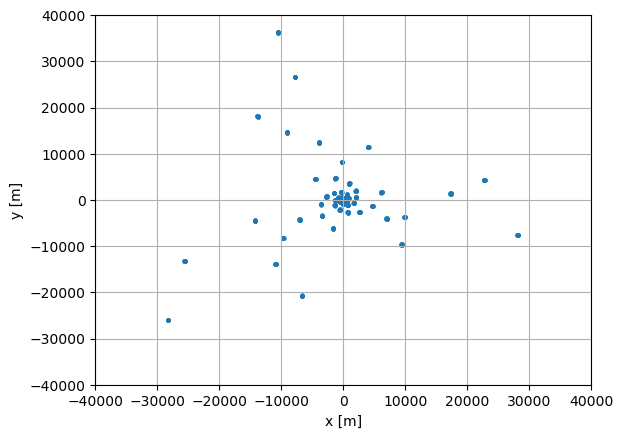

(None, None)

<Figure size 640x480 with 0 Axes>

In [5]:
layout = np.loadtxt('skalow_layout.txt', usecols=(0,1))

plt.scatter(layout[:,0], layout[:,1], s=5, color='tab:blue')
plt.grid(), plt.xlabel('x [m]'), plt.ylabel('y [m]')
plt.xlim(-40000, 40000), plt.ylim(-40000, 40000)
plt.show(), plt.clf()

## Number of baselines

The baselines, $ \mathbf{b} $, is the distance between a pair of stations/antennas (i.e., all possible antenna combinations). For a given number of stations/antennas, $N_{\rm ant}$, we can have a total of baselines:

$$N_B = \frac{N_{\rm ant}\cdot (N_{\rm ant} - 1)}{2} $$

In [7]:
N_ant = layout.shape[0]
N_B = int(N_ant*(N_ant-1)/2)

print('N_ant =', N_ant)
print('N_B =', N_B)

N_ant = 512
N_B = 130816


## The $uv$-coverage and coordinates

In the previous tutorials we mentioned as an interferometry telescope measures components of the sky Fourier Transform through the sampling of the Visibility function $V_{ij}$. Each pair of antennas (i.e.: baseline), $ \vec{b}_{ij} $, probes a particular Fourier mode of the sky signal. 

This collection of samples is located in the ($u$, $v$, $w$) space and are often projected into a plane, the $uv$-plane, defined as:

$$  \frac{\vec{b}}{\lambda} = \frac{1}{\lambda}\begin{pmatrix}x \\ y \\ z \end{pmatrix} = \begin{pmatrix}u \\ v \\ w \end{pmatrix}$$

The $uv$-coverage of an observation is a way to know which portion of the visibility function (frequency domain) is sampled.

## The $uv$-plane from a telescope layout
To obtain the corresponding $uv$-coordinates from the $XYZ$-coordinates (cartesian) of the antennas on Earth in radio interferometry, you need to calculate the baseline vectors between pairs of antennas. 

In [8]:
# define observed frequency and corresponding wavelenght
freq = 200*u.MHz
lam = (cst.c/freq).to('m')

# get pair of 
pair_comb = list(itertools.combinations(range(N_ant), 2))

assert np.shape(pair_comb)[0] == N_B


baselines = np.empty((N_B, 2))

for i in tqdm(range(N_B)):
    ii, jj = pair_comb[i]
    
    # calculate the distance between antennas
    uv = (layout[ii]-layout[jj])/lam
    baselines[i] = uv

# add units
baselines /= u.m

100%|████████████████████████████████| 130816/130816 [00:01<00:00, 96090.94it/s]


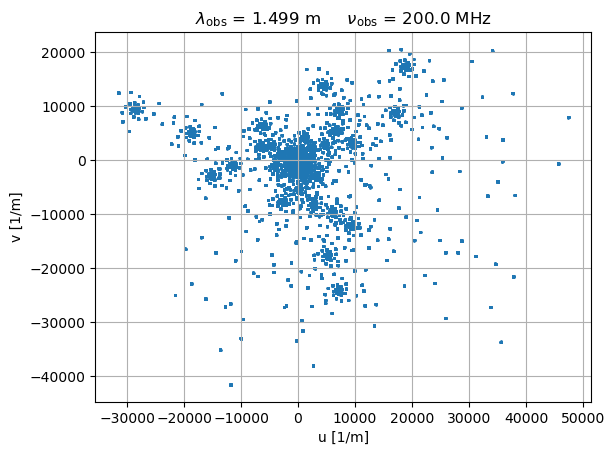

(None, None)

<Figure size 640x480 with 0 Axes>

In [9]:
# Plot the baselines in the uv-plane
plt.title(r'$\lambda_{\rm obs}$ = %.3f %s     $\nu_{\rm obs}$ = %.1f %s' %(lam.value, lam.unit, freq.value, freq.unit))
plt.scatter(baselines[:,0], baselines[:,1], s=1, color='tab:blue')
plt.grid(), plt.xlabel('u [1/m]'), plt.ylabel('v [1/m]')
plt.show(), plt.clf()

## Earth rotation & $uv$-coverage